# Custom priors

Let's look at something a bit more complicated now, using custom priors to define the model instead of the pb1 and pb2 models provided by Maelstrom.

In [1]:
from maelstrom.orbit import Orbit
import numpy as np
import exoplanet as xo
from maelstrom import Maelstrom
import matplotlib.pyplot as plt

/Users/danielhey/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:212: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Plotting PDCSAP_FLUX. You can remove this warning by using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


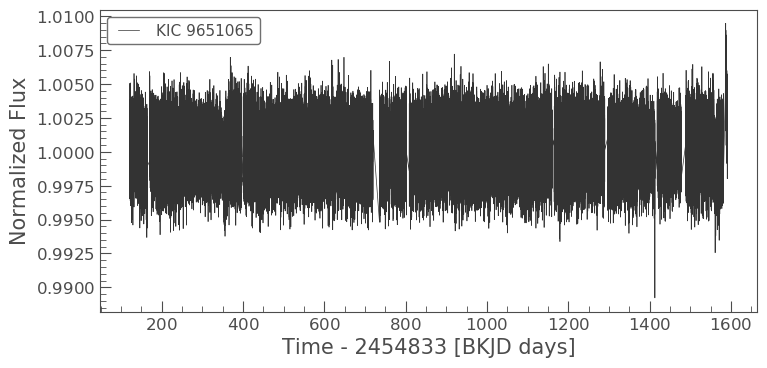

In [2]:
import lightkurve as lk

lc = lk.search_lightcurvefile('KIC 9651065', mission='Kepler').download_all().stitch().remove_nans()
lc.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2976de80>,
      dtype=object)

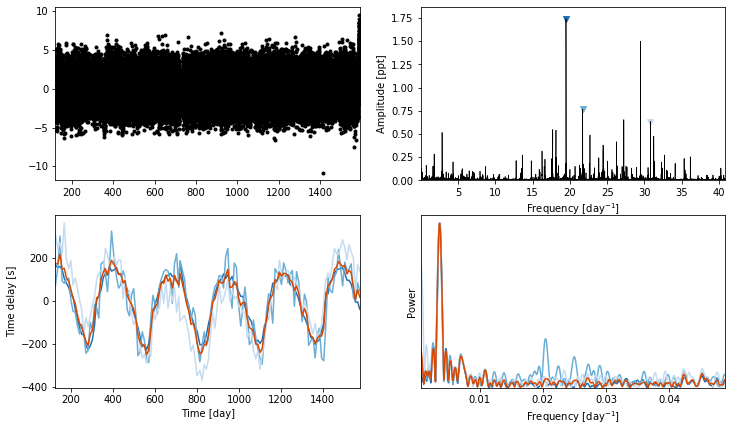

In [3]:
ms = Maelstrom(lc.time, lc.flux, max_peaks=3, fmax=48)
ms.first_look()

In [4]:
freq = ms.freq
time, flux = ms.time, ms.flux

Here is where we define our custom model. PyMC3 has a steep learning curve, so I recommend reading the tutorials or the introduction by ...

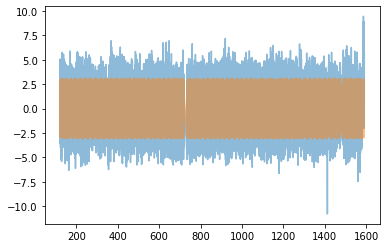

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    # Our orbital period prior
    period = pm.Normal("period", mu=300, sd=50)
    # The phase of conjunction
    phi = xo.distributions.Angle("phi")
    # Our standard deviation
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    # We want positive lighttimes only, sample in log-space
    logasini = pm.Normal('logasini', mu=np.log(200), sd=100, testval=np.log(200))
    asini = pm.Deterministic("asini", pm.math.exp(logasini))
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", pm.math.exp(lognu))
    
    # Here, we generate an Orbit instance and pass in our priors. 
    orbit = Orbit(period=period, 
                  lighttime=asini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu)
    
    # Orbit makes available a method which will calculate the theoretical light curve given the orbital parameters, times, and fluxes, following
    # equation 10 of the paper. 
    lc = orbit.get_lightcurve_model(time, flux) + mean
    
    # We pass this into our likelihood
    pm.Normal('obs', mu=lc, sd=tt.exp(logs_lc), observed=flux)

# This is what our light curve looks like before any optimisation
with model:
    plt.plot(time, flux, alpha=0.5)
    plt.plot(time, xo.eval_in_model(lc), alpha=0.5)

In [6]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[period])
    map_params = xo.optimize(start=map_params, vars=all_but)

[period, phi_angle__, logs_lc, logasini, omega_angle__, eccen_interval__, mean, lognu]


optimizing logp for variables: [mean]
5it [00:00,  5.40it/s, logp=-1.119855e+05]
message: Optimization terminated successfully.
logp: -111985.6908205761 -> -111985.54397631987
optimizing logp for variables: [logs_lc]
9it [00:00, 30.61it/s, logp=-1.078247e+05]
message: Optimization terminated successfully.
logp: -111985.54397631987 -> -107824.74147651007
optimizing logp for variables: [omega, eccen]
32it [00:01, 25.46it/s, logp=-1.075212e+05]
message: Optimization terminated successfully.
logp: -107824.74147651007 -> -107521.1612666544
optimizing logp for variables: [phi]
90it [00:03, 28.65it/s, logp=-1.074983e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -107521.1612666544 -> -107498.32770824614
optimizing logp for variables: [lognu, mean, eccen, omega, logasini, logs_lc, phi, period]
187it [00:07, 25.41it/s, logp=-1.064790e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -107498.32770824614 -> -106479.01236347636
opt

In [7]:
map_params

{'period': array(272.00127765),
 'phi_angle__': array([2.41012264, 3.76717216]),
 'logs_lc': array(0.21291784),
 'logasini': array(5.22159273),
 'omega_angle__': array([-3.61203158,  2.63690969]),
 'eccen_interval__': array(0.03306721),
 'mean': array(0.00075123),
 'lognu': array([2.96926914, 3.07787136, 3.42757631]),
 'phi': array(0.5691498),
 'asini': array(185.22896978),
 'omega': array(-0.9401957),
 'eccen': array(0.45743945),
 'nu': array([19.47767893, 21.71213593, 30.80189809])}